# Step 1: Import Modules and Load Dataset

In [1]:
# Import packages
import plotly.graph_objs as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load salesdata
df = pd.read_csv("src/sales_clean.csv")

# Select relevant columns
selected_columns = ['date', 'store_nbr', 'unit_sales']
df = df[selected_columns]

# Choose the store you want to forecast
store_to_forecast = 49

# Select only sales of store 1
df = df[df['store_nbr'] == store_to_forecast]

# Drop the store_nbr column
df.drop(columns=['store_nbr'], inplace=True) # Inplace = True ensures that a copy is NOT returned.

# Step 2: Data Cleaning

#### We format the date table

#### We remove negative unit_sales since these represent returns. Returns are not significant for the forecasting of total unit sales. Additionally, the percentage of negative sales is less than 6.10^-3 percent.

#### We remove a singular outlier of 9610 unit sales since it is highly unlikely that a singular item was purchased that many times in a single day. Additionally, the vast majority of unit sales is between 0 and 1000.

In [2]:
#Format the date column
df['date'] = pd.to_datetime(df['date'])

# Remove rows with negative unit_sales
df = df[df['unit_sales'] >= 0]
    
# Remove entries where the sales exceed 4000
df = df[df["unit_sales"] <= 4000]

# Since the data will be aggregated per month and we only have data for half of August 2017, we drop those rows aswell
df = df[df['date'] <= '2017-07-31']

# Format unit_sales to int
df['unit_sales'] = df['unit_sales'].astype(int)

# Print dataframe information
print(df.shape)
for col in df.columns:
    print("_______________________________________________")
    print(f"The type of {col} is {df[col].dtype}")
    print(f"The minimum value of column {col} is {df[col].min()}")
    print(f"The maximum value of column {col} is {df[col].max()}")

(2065296, 2)
_______________________________________________
The type of date is datetime64[ns, UTC]
The minimum value of column date is 2013-01-01 00:00:00+00:00
The maximum value of column date is 2017-07-31 00:00:00+00:00
_______________________________________________
The type of unit_sales is int32
The minimum value of column unit_sales is 0
The maximum value of column unit_sales is 2750


# Step 3: Aggregate Data

#### We aggregate the data so that it represents the total unit sales for a singular store during a singular day. In other words, the amount of items a certain store sold at a certain day

#### We plot the total unit sales for store 1 for reference

In [3]:
# RUN THIS CELL ONLY ONCE
# Set 'Date' column as the index
df.set_index('date', inplace=True)

# Group by month and aggregate the sales
df = df.resample('M').sum()
df.index= df.index.strftime('%Y-%m-01')

(55, 1)
_______________________________________________
The type of unit_sales is int32
The minimum value of column unit_sales is 161623
The maximum value of column unit_sales is 497004


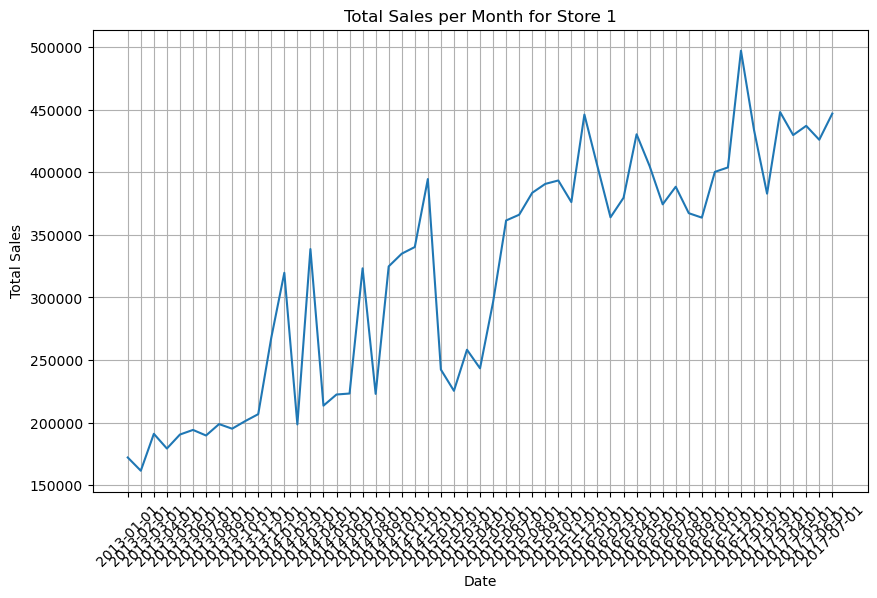

In [4]:
# Print dataframe information
print(df.shape)
for col in df.columns:
    print("_______________________________________________")
    print(f"The type of {col} is {df[col].dtype}")
    print(f"The minimum value of column {col} is {df[col].min()}")
    print(f"The maximum value of column {col} is {df[col].max()}")
    
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['unit_sales'])
plt.title('Total Sales per Month for Store 1')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

# Step 4: Split the data

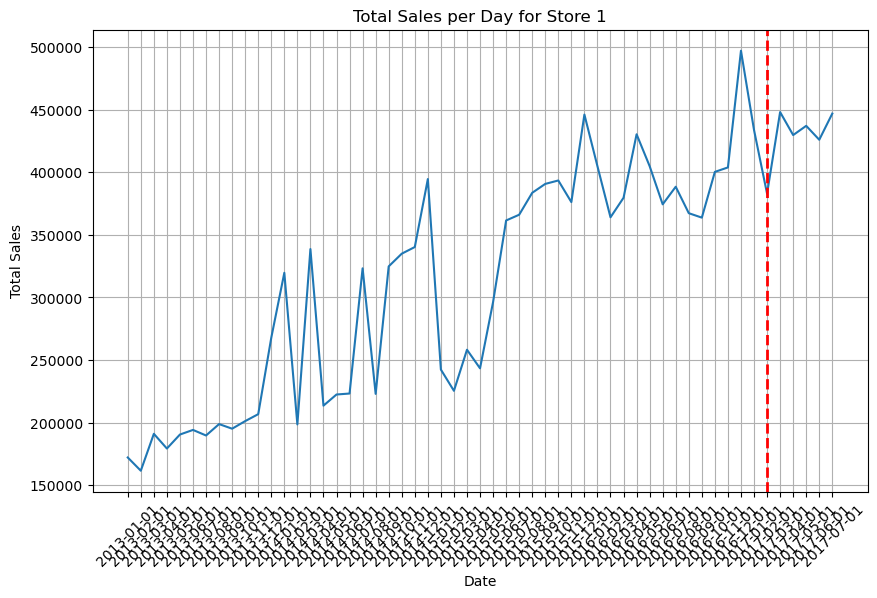

In [5]:
# Define the last date used in the training data
MAX_TRAINING_DATE = df.index[df.shape[0] - 6]

# Plot the data and a vertical line indicating the training data cutoff point
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['unit_sales'])
plt.axvline(x=MAX_TRAINING_DATE, color='r', linestyle='--', linewidth=2)
plt.title('Total Sales per Day for Store 1')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

# Split the data into training data and testing data
df_train = df.loc[df.index <= MAX_TRAINING_DATE, :]
df_test = df.loc[df.index > MAX_TRAINING_DATE, :]

# Step 5: The model

#### We create and fit the SARIMAX model
#### Finally we make the forecast and plot it

C:\Users\tangu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\tangu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\tangu\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


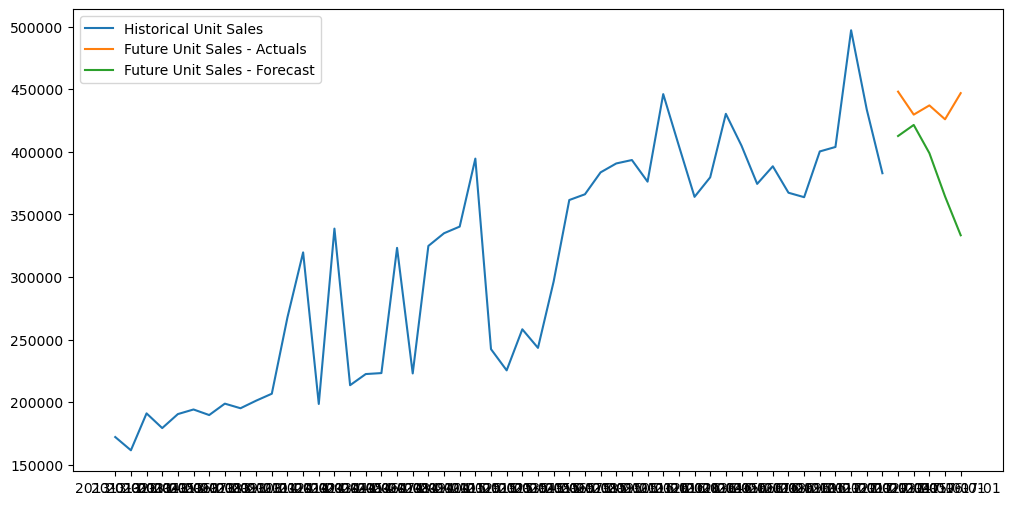

In [6]:
# Create and fit SARIMAX model, the integers inserted here are explained in my written notebook
model = SARIMAX(
    df_train['unit_sales'],
    order = (1, 2, 2), # p, d, q order parameters for arima
    trend = [1,1],  # A(t) = a0 + a1*t + a2*t^2 ... 
    seasonal_order=(1, 2, 2, 12) # P, D, Q seasonal order parameters
)

results = model.fit()

# Make forecast
forecast = results.forecast(steps=df_test.shape[0])  # Forecast for the next 5 months

# Plot actual sales and forecast
plt.figure(figsize = (12, 6))
plt.plot(df_train.index, df_train['unit_sales'], label='Historical Unit Sales')
plt.plot(df_test.index, df_test['unit_sales'], label='Future Unit Sales - Actuals')
plt.plot(df_test.index, forecast, label='Future Unit Sales - Forecast')
plt.legend()
plt.show()

# Lesson Learned: Remember that ChatGPT has been trained on data up to 2021. 
Specifically in this case, I tried to forecast using an outdated module called fbprophet. Turns out that the module underwent a name change to prophet in 2022. Therefore I was unable to install it and had to resort to ARIMA / SARIMAX modeling in the statsmodels module, which is a much more complex tool for forecasting. This in turn caused me to lose a lot of time understanding the module.